In [14]:
import sys
sys.path.append('../src')

import importlib
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from sklearn.metrics import mean_squared_error as mse

import bbDebiasing as bbDebias
import maxEnsembleDebias as maxDebias
import policies

# Initial Experiments: Sanity Checking Using 3-Datapoint Dataset

### Bias Bounties Style Updates

In [15]:
importlib.reload(bbDebias)
importlib.reload(policies)

xs = np.array([[1],[2],[3]]) 
ys = np.array([[1,10], [2,1], [4,0]])

def h0(xs):
    preds = []
    for x in xs:
        if x==1:
            preds.append([3.,9.])
        if x==2:
            preds.append([1,0])
        if x==3:
            preds.append([1,0])
    return np.array(preds)

def h1(xs):
    preds = []
    for x in xs:
        if x==1:
            preds.append([1.,0.])
        if x==2:
            preds.append([0,1])
        if x==3:
            preds.append([0,1])
    return np.array(preds)

def h2(xs):
    preds = []
    for x in xs:
        if x==1:
            preds.append([0.,1.])
        if x==2:
            preds.append([1,0])
        if x==3:
            preds.append([0,1])
    return np.array(preds)

def h3(xs):
    preds = []
    for x in xs:
        if x==1:
            preds.append([0.,1.])
        if x==2:
            preds.append([0,1])
        if x==3:
            preds.append([1,0])
    return np.array(preds)

max_depth = 20
pred_dim = 2
policy0 = policies.Simplex(pred_dim, h0)
policy1 = policies.Simplex(pred_dim, h1)
policy2 = policies.Simplex(pred_dim, h2)
policy3 = policies.Simplex(pred_dim, h3)

max_depth = 40
tolerance = 0.1 # after MSE improvement drops below this, halt debiasing process
model = bbDebias.bbDebias(h0, policy0, xs, ys, max_depth, tolerance)

model.debias([h1,h2,h3],[policy1,policy2,policy3])

Hit tolerance; halting debiasing.


Text(0.5, 1.0, 'BB Alg: MSE over Rounds, by Policy')

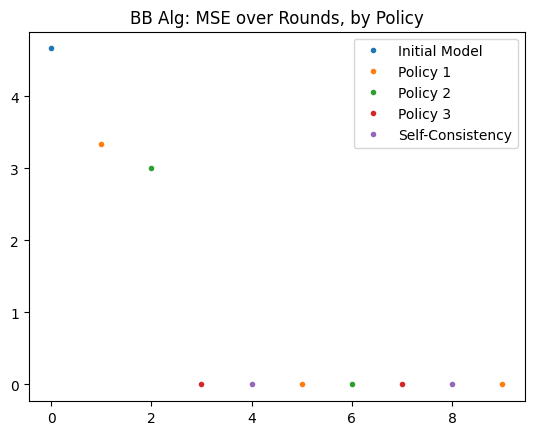

In [16]:
# generate MSE for each round 

mses = np.array([mse(ys, pred, multioutput='raw_values') for pred in model.predictions_by_round])

coord = 0
plt.plot(0,mses[0][coord],'.', label="Initial Model")
for i in range(1, model.n_models+1):
    indices = list(range(len(model.predictions_by_round)))[i::(model.n_models + 1)]
    plt.plot(indices, mses[i::(model.n_models + 1)][:, coord], '.', label=f"Policy {i}")
indices = list(range(len(model.predictions_by_round)))[(model.n_models+1)::(model.n_models + 1)]
plt.plot(indices, mses[(model.n_models+1)::(model.n_models + 1)][:, coord], '.', label="Self-Consistency")
plt.legend()
plt.title("BB Alg: MSE over Rounds, by Policy")

Text(0.5, 1.0, 'BB Alg: Predicted and Realized Revenue over Rounds')

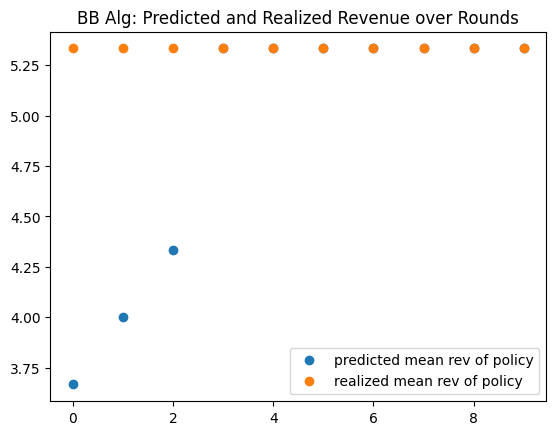

In [17]:
# predicted revenue of each point per round
pred_rev = [np.einsum('ij,ij->i', model.predictions_by_round[i], policy0.run_given_preds(model.predictions_by_round[i])) for i in range(len(model.predictions_by_round))] #fancy vectorized row-wise dot product 
# realized revenue
true_rev = [np.einsum('ij,ij->i', ys, policy0.run_given_preds(model.predictions_by_round[i])) for i in range(len(model.predictions_by_round))]


plt.plot(range(len(model.predictions_by_round)), np.mean(pred_rev, axis=1), 'o', label="predicted mean rev of policy")
plt.plot(range(len(model.predictions_by_round)), np.mean(true_rev, axis=1), 'o', label="realized mean rev of policy")
plt.legend()
plt.title("BB Alg: Predicted and Realized Revenue over Rounds")

### Max Ensemble Approach

In [18]:
importlib.reload(maxDebias)
importlib.reload(policies)

xs = np.array([[1],[2],[3]]) 
ys = np.array([[1,10], [2,1], [4,0]])
pred_dim = 2

def h0(xs):
    preds = []
    for x in xs:
        if x==1:
            preds.append([3.,9.])
        if x==2:
            preds.append([1,0])
        if x==3:
            preds.append([1,0])
    return np.array(preds)

def h1(xs):
    preds = []
    for x in xs:
        if x==1:
            preds.append([1.,0.])
        if x==2:
            preds.append([0,10])
        if x==3:
            preds.append([0,2])
    return np.array(preds)

policy0 = policies.Simplex(pred_dim, h0)
policy1 = policies.Simplex(pred_dim, h1)


model = maxDebias.EnsembledModel([h0,h1], [policy0, policy1], xs, ys, 5, 0.1)
model.debias()
out, transcript = model.predict(xs)


Maximum depth reached.


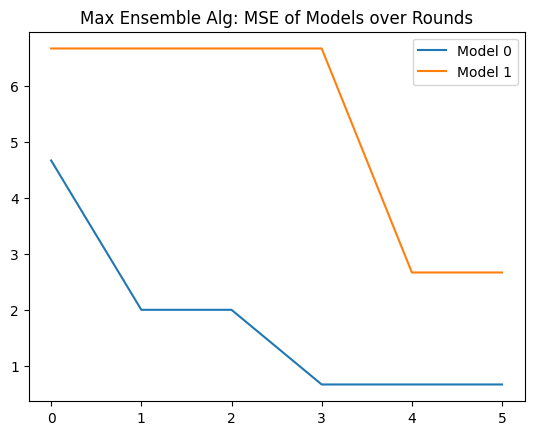

In [19]:
preds = np.array(model.predictions_by_round)

preds_by_model = [preds[:,i] for i in range(model.n_models)]
mses_by_model = np.zeros((len(preds_by_model), len(preds), model.pred_dim))
for i in range(model.n_models):
    for j in range(len(preds_by_model[i])):
        mses_by_model[i][j] = mse(ys, preds_by_model[i][j], multioutput='raw_values')

coord = 0
for i in range(model.n_models):
    plt.plot(np.arange(len(model.predictions_by_round)), mses_by_model[i][:,coord], label=f"Model {i}")
plt.legend()
plt.title("Max Ensemble Alg: MSE of Models over Rounds");

Text(0.5, 1.0, 'Max Ensemble Alg: Average Predicted and Realized Revenue of Policies')

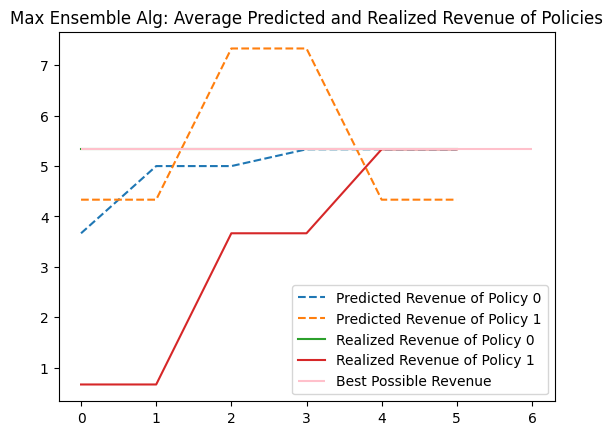

In [20]:
pred_rev = [[np.mean(np.einsum('ij, ij->i', preds_by_model[i][j], model.policies[i].run_given_preds(preds_by_model[i][j]))) for j in range(len(preds_by_model[i]))] for i in range(model.n_models)]
realized_rev = [[np.mean(np.einsum('ij, ij->i', ys, model.policies[i].run_given_preds(preds_by_model[i][j]))) for j in range(len(preds_by_model[i]))] for i in range(model.n_models)]

n = len(model.predictions_by_round)
for i in range(model.n_models):
    plt.plot(np.arange(n), pred_rev[i], '--', label=f"Predicted Revenue of Policy {i}")
for i in range(model.n_models):
    plt.plot(np.arange(n), realized_rev[i], label=f"Realized Revenue of Policy {i}")

plt.hlines(np.mean(np.einsum('ij, ij->i', ys, model.policies[0].run_given_preds(ys))), 0, n, label="Best Possible Revenue", color='pink')
plt.legend()
plt.title("Max Ensemble Alg: Average Predicted and Realized Revenue of Policies")

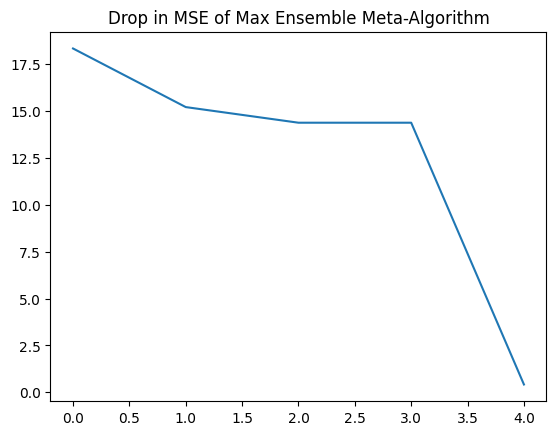

In [21]:
ensemble_mse = np.array([mse(ys, model.meta_model_pred_by_round[i]) for i in range(len(model.meta_model_pred_by_round))])
coord = 0

plt.plot(np.arange(len(ensemble_mse)), ensemble_mse)
plt.title("Drop in MSE of Max Ensemble Meta-Algorithm")

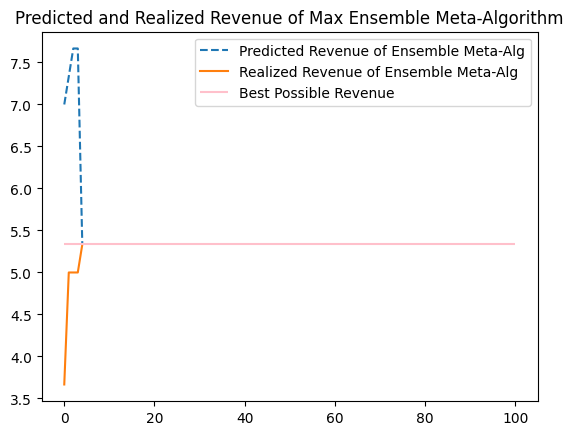

In [22]:
pred_rev = [np.mean(np.einsum('ij, ij->i', model.meta_model_pred_by_round[i], model.meta_policy_choice_by_round[i])) for i in range(len(model.meta_model_pred_by_round))]
realized_rev = [np.mean(np.einsum('ij, ij->i', ys, model.meta_policy_choice_by_round[i])) for i in range(len(model.meta_model_pred_by_round))] 

plt.plot(np.arange(len(model.meta_model_pred_by_round)), pred_rev, '--', label="Predicted Revenue of Ensemble Meta-Alg")
plt.plot(np.arange(len(model.meta_model_pred_by_round)), realized_rev, label="Realized Revenue of Ensemble Meta-Alg")
plt.hlines(np.mean(np.einsum('ij, ij->i', ys, model.policies[0].run_given_preds(ys))), 0, 100, label="Best Possible Revenue", color='pink')
plt.legend()
plt.title("Predicted and Realized Revenue of Max Ensemble Meta-Algorithm");